In [1]:
from model import DogIdentificationModel
from params import DEVICE, CPU_DEVICE
from data_loader_test_pipeline import DogsDataSet_Test_Pipeline
from triplet_loss import sigmoidL2
from torchvision import transforms
import torch
from tqdm import tqdm
import pandas as pd
import torchvision.models as models
from torch import nn
import random

## Passing Images Through Dog Comparator

In [2]:
# Loading model
model = DogIdentificationModel()

In [3]:
# Moving to training device
model = model.to(DEVICE)

In [4]:
checkpoint = torch.load('dog-identification-model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
BATCH_SIZE = 30

In [68]:
# Defining the validation data loader
validationData = DogsDataSet_Test_Pipeline(dataType='validation')

# Defining the Validation data loader
validationLoader = torch.utils.data.DataLoader(validationData, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=4)

In [7]:
# Defining empty list to hold results
results = []

# Turning off the gradient
with torch.no_grad():
    
    # Turning model to evaluation
    model = model.eval()

    # Iterating through every image
    for index in range(0, validationData.__len__()):
        # Getting the images
        img1_transformed, img2_transformed, _, _, targetDogPath = validationData.__getitem__(index)

        # Reshaping the images
        img1_transformed = img1_transformed.unsqueeze(0)
        img2_transformed = img2_transformed.unsqueeze(0)

        # Moving to GPU
        img1_transformed = img1_transformed.to(DEVICE)
        img2_transformed = img2_transformed.to(DEVICE)

        # Computing the encoding
        img1Encoding = model(img1_transformed)
        img2Encoding = model(img2_transformed)       

        # Moving encoding to CPU
        img1Encoding = img1Encoding.to(CPU_DEVICE)
        img2Encoding = img2Encoding.to(CPU_DEVICE)

        # Appending Results
        results.append([targetDogPath, img1Encoding, img2Encoding])

In [8]:
# Deleting model from memory
del model

In [9]:
# Converting results to df
results_dog_comparator = pd.DataFrame(results, columns=['path', 'img1_encoding', 'img2_encoding'])

## Passing Images Through Dog Breed Identifier

In [10]:
# Loading the pre-trained model
model_vgg19 = models.vgg19(pretrained=True)

# Adjusting the classifier layuers
model_vgg19.classifier = nn.Sequential(
    *list(model_vgg19.classifier.children())[:-1] + [nn.Linear(in_features=4096, out_features=120, bias=True)]
)
# Loading the model
model_vgg19.load_state_dict(torch.load('vgg19_60_based_model2.pt'), strict=False)

# Turning to eval model
model_vgg19.eval()

# Passing to GPU
model_vgg19 = model_vgg19.to(DEVICE)

In [11]:
# Defining the transformations for each image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]                     
    )
])

In [12]:
# Reading in breed classes
with open("stanford_dogs_breeds_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [13]:
# Defining empty list to hold results
results = []

# Turning off the gradient
with torch.no_grad():
    # Iterating through every image
    for index in range(0, validationData.__len__()):
        # Getting the images
        _, _, img1, img2, targetDogPath = validationData.__getitem__(index)
        
        img1_transformed = preprocess(img1)
        img2_transformed = preprocess(img2)
        
        # Reshaping the images
        img1_transformed = img1_transformed.unsqueeze(0)
        img2_transformed = img2_transformed.unsqueeze(0)

        # Moving to GPU
        img1_transformed = img1_transformed.to(DEVICE)
        img2_transformed = img2_transformed.to(DEVICE)

        # Computing the encoding
        img1_breed = model_vgg19(img1_transformed)
        img2_breed  = model_vgg19(img2_transformed)    
        
        img1_breed_prob = torch.nn.functional.softmax(img1_breed[0], dim=0)
        img2_breed_prob = torch.nn.functional.softmax(img2_breed[0], dim=0)

        # Moving encoding to CPU
        img1_breed_prob = img1_breed_prob.to(CPU_DEVICE)
        img2_breed_prob = img2_breed_prob.to(CPU_DEVICE)

        # Appending Results
        results.append([targetDogPath, img1_breed_prob, img1_breed_prob])

In [14]:
# Converting results to df
results_dog_breed = pd.DataFrame(results, columns=['path', 'img1_breeds', 'img2_breeds'])

## Experiment

In [15]:
resultsDF = pd.merge(results_dog_breed,results_dog_comparator)

In [16]:
# Setting random seed
random.seed(1)

# Randomly select 10% of the dogs from the available dogs
foundDogsIndexes = random.sample(range(0, len(resultsDF)), int(len(resultsDF)*0.1))

In [17]:
# Subsetting the lost and found dogs
foundDogs = resultsDF[['img1_breeds', 'img1_encoding', 'path']].iloc[foundDogsIndexes]

# Subsetting the lost and found dogs
lostDogs = resultsDF[['img2_breeds', 'img2_encoding', 'path']]

In [18]:
# Creating empty array to hold the number of times we found the lost dog
numTimesFound = torch.zeros((10, 10, 15))

In [19]:
# Iterating through every lost rog
for index, foundDog in foundDogs.iterrows():
    
    # Iterating through the comparison parameters
    for topBreedLostCount in range(1,11):
        
        for topBreedFoundCount in range(1,11):            
            # Computing the top "topBreedFoundCount" breeds of the found dog
            prob, catID = torch.topk(foundDog['img1_breeds'], topBreedFoundCount)
            
            # Determing the dogs that have the at least 1 of the "topBreedFoundCount" breeds in their 
            # "topBreedLostCount" breeds            
            topKBreeds = lostDogs['img2_breeds'].apply(
                lambda breedProbs: torch.topk(breedProbs, topBreedLostCount)[1].tolist()
            )
            
            hasCorrectBreeds = topKBreeds.apply(
                lambda topBreedIDs: any(item in topBreedIDs for item in catID)
            )      
            
            # Subsetting accordingly
            lostDogsWithBreed = lostDogs[hasCorrectBreeds][['img2_encoding', 'path']]    
            
            # Defining list to record results
            comparisonResults = []
            
            # Iterating through the lost dogs with the correct breed(s)
            for index, lostDog in lostDogsWithBreed.iterrows():
                # Determing the similarity btw the lost and found dog
                similarity = sigmoidL2(foundDog['img1_encoding'],lostDog['img2_encoding'])
                
                # Extracting the similarity
                similarity = similarity[0].item()
                
                pathFound = foundDog['path']
                
                pathLost = lostDog['path']
                
                comparisonResults.append([similarity, pathFound, pathLost])
  
            # Sorting results by most similar to least similar
            comparisonResults.sort(key = lambda x: x[0])
        
            # Iterating through the number of dogs returned to the user
            for dogsReturnedCount in range(1, 16):
                comparisonResultsReduced = comparisonResults[0:dogsReturnedCount]
                
                for comparison in comparisonResultsReduced:
                    if comparison[1] == comparison[2]:
                        numTimesFound[topBreedLostCount-1, topBreedFoundCount-1, dogsReturnedCount-1] += 1
                        
                
#                 break
#             break
#         break
    
#     break

In [20]:
# Extracting the percentage
numTimesFound = numTimesFound / len(foundDogs)

In [21]:
# Defining list to hold results
results = []

# Flattening tensor into custom list
for topBreedLostCount in range(1,11):
    for topBreedFoundCount in range(1,11):
        for dogsReturnedCount in range(1, 16):
            
            # Extracting the parameters
            parameters = (topBreedLostCount, topBreedFoundCount, dogsReturnedCount)
            
            # Extracting the value
            value = numTimesFound[topBreedLostCount-1, topBreedFoundCount-1, dogsReturnedCount-1].item()
            
            # Appending to the list
            results.append([value, parameters])                

In [22]:
results.sort(key = lambda x: x[0])

In [23]:
results.reverse()

In [24]:
results

[[0.9800000190734863, (1, 1, 15)],
 [0.9800000190734863, (1, 1, 14)],
 [0.9800000190734863, (1, 1, 13)],
 [0.9399999976158142, (1, 1, 12)],
 [0.8999999761581421, (2, 1, 15)],
 [0.8999999761581421, (1, 1, 11)],
 [0.8999999761581421, (1, 1, 10)],
 [0.8999999761581421, (1, 1, 9)],
 [0.8799999952316284, (2, 1, 14)],
 [0.8799999952316284, (1, 2, 15)],
 [0.8600000143051147, (2, 1, 13)],
 [0.8600000143051147, (1, 2, 14)],
 [0.8600000143051147, (1, 1, 8)],
 [0.8399999737739563, (3, 1, 15)],
 [0.8399999737739563, (3, 1, 14)],
 [0.8399999737739563, (2, 1, 12)],
 [0.8399999737739563, (2, 1, 11)],
 [0.8399999737739563, (2, 1, 10)],
 [0.8199999928474426, (4, 1, 15)],
 [0.8199999928474426, (4, 1, 14)],
 [0.8199999928474426, (3, 1, 13)],
 [0.8199999928474426, (3, 1, 12)],
 [0.8199999928474426, (2, 1, 9)],
 [0.8199999928474426, (1, 3, 15)],
 [0.8199999928474426, (1, 2, 13)],
 [0.8199999928474426, (1, 2, 12)],
 [0.8199999928474426, (1, 2, 11)],
 [0.8199999928474426, (1, 2, 10)],
 [0.8199999928474426, (

In [25]:
pd.DataFrame(results, columns=['dogs_returned','parameters']).to_csv('pipeline_results_validation.csv')

In [30]:
validationResults = pd.read_csv('pipeline_results_validation.csv', index_col=0)

In [41]:
from ast import literal_eval

validationResults['numComparisons'] = validationResults['parameters'].apply(
    lambda row: literal_eval(row)[0] * literal_eval(row)[1]
)

In [45]:
aggAccr = validationResults.groupby('numComparisons').mean().reset_index()

In [51]:
import matplotlib.pyplot as plt

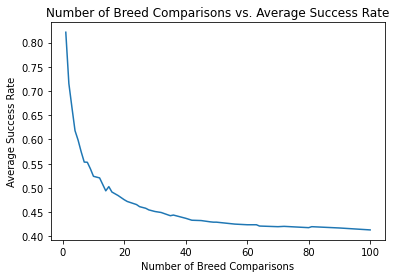

In [65]:
plt.plot(aggAccr['numComparisons'], aggAccr['dogs_returned'])
plt.xlabel('Number of Breed Comparisons')
plt.ylabel('Average Success Rate')
plt.title('Number of Breed Comparisons vs. Average Success Rate')
plt.savefig('num_breed_comparison_accuracy.png')
plt.show()

In [66]:
pd.read_csv('pipeline_results_test.csv')

,Unnamed: 0,dogs_returned,parameters
0,0,0.887931,"(1, 1, 15)"
1,1,0.853448,"(1, 1, 14)"
2,2,0.844828,"(1, 1, 13)"
3,3,0.818965,"(1, 1, 12)"
4,4,0.801724,"(2, 1, 15)"
...,...,...,...
1495,1495,0.025862,"(5, 9, 1)"
1496,1496,0.025862,"(5, 8, 1)"
1497,1497,0.025862,"(5, 7, 1)"
1498,1498,0.025862,"(4, 10, 1)"
